In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time

#Rice Image Data

This data comes from the kaggle site: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset and is a collection of rice grain images from 5 different types of rice. The data is originally from the paper, "Classification of rice varieties with deep learning methods" by Koklu, Cinat, and Taspinar. The dataset was originally collected in order to advance the uses of deep learning models on the classification of different grains.

In [2]:
#Load in data from kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip -q rice-image-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 74% 163M/219M [00:00<00:00, 1.70GB/s]
100% 219M/219M [00:00<00:00, 1.70GB/s]


In [3]:
def im_to_gray(image): #Function to convert all the images to grayscale
  weights = np.array([0.299, 0.587, 0.114]) #Weights I found online for converting to grayscale
  return np.dot(image[..., :3], weights)

In [4]:
#Load in the images and store them in one large list, also set up list of labels
def load_data():
  rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
  labels = []
  images = np.zeros((75000,250,250))
  counter = 0
  for rice in rice_types:
    folder_path = "Rice_Image_Dataset/" + rice
    for item_name in tqdm(os.listdir(folder_path)):
          item_path = os.path.join(folder_path, item_name)
          pil_image = Image.open(item_path)
          images[counter] = im_to_gray(np.array(pil_image))
          counter += 1
          labels.append(rice)
  return np.array(labels), images

In [5]:
labels, images = load_data()

100%|██████████| 15000/15000 [00:30<00:00, 486.92it/s]


#Deep Learning Problem

The deep learning problem here is one of quick classification. There are multiple hypothetical situations where a model like this could be useful. One of these could be a plant processing rice grains, that needs a machine that can quickly sort the types of rice into seperate piles for shipping. Another could be a model that verifies that rice is a specific type of grain when people are trying to sell it. Overall, this is not an incredibly important problem that needs to be solved, but I think that the process of doing this will help develop my knowledge of deep learning. This problem is similar to the cancer dataset we worked with in an earlier project, being an image classification task, but this one adds to that by having multiple categories to sort into.

#EDA and Data Transformation

Below is my EDA and data transformations. Since I am working with image data, there is not a lot of EDA that can be done, so I will look at the counts of the categories and display some images. After this I will see if any data transformations should be done to the images.

###Look at Category Counts

The code below generates every unique label for the data, as well as the counts. We can see that there are five categories of rice, and the categories are balanced with 15,000 images each, for 75,000 images total.

In [6]:
#Check unique counts
np.unique(labels, return_counts=True)

(array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],
       dtype='<U9'),
 array([15000, 15000, 15000, 15000, 15000]))

###Plot Images for Rice Types

For my EDA, I decided to look at three images from each rice type in order to see how much of a difference there is between them. The code below plots the first three images for each type of rice. Each of the types does seem to look somewhat different, with basmati and jasmine looking long and thin hile the other three look shorter and wider. Hopefully this means that a model will be able to easilly differentiate between the rice types.

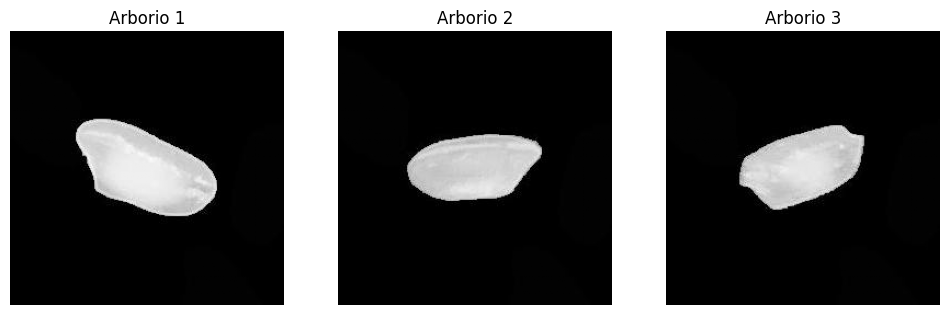

In [7]:
#Plot for Arborio
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[0], cmap='gray')
axes[0].set_title('Arborio 1')
axes[0].axis('off')
axes[1].imshow(images[1], cmap='gray')
axes[1].set_title('Arborio 2')
axes[1].axis('off')
axes[2].imshow(images[2], cmap='gray')
axes[2].set_title('Arborio 3')
axes[2].axis('off')
fig.show()

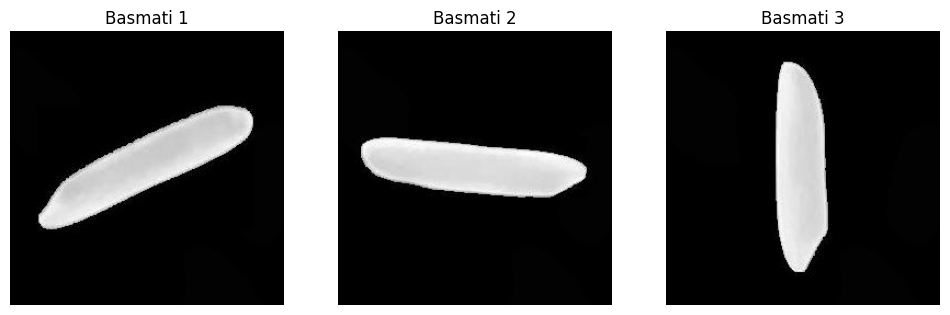

In [8]:
#Plot for Basmati
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[15000], cmap='gray')
axes[0].set_title('Basmati 1')
axes[0].axis('off')
axes[1].imshow(images[15001], cmap='gray')
axes[1].set_title('Basmati 2')
axes[1].axis('off')
axes[2].imshow(images[15002], cmap='gray')
axes[2].set_title('Basmati 3')
axes[2].axis('off')
fig.show()

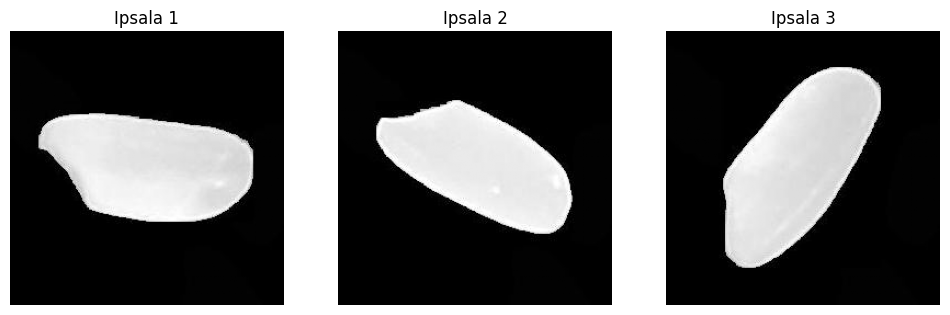

In [9]:
#Plot for Ipsala
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[30000], cmap='gray')
axes[0].set_title('Ipsala 1')
axes[0].axis('off')
axes[1].imshow(images[30001], cmap='gray')
axes[1].set_title('Ipsala 2')
axes[1].axis('off')
axes[2].imshow(images[30002], cmap='gray')
axes[2].set_title('Ipsala 3')
axes[2].axis('off')
fig.show()

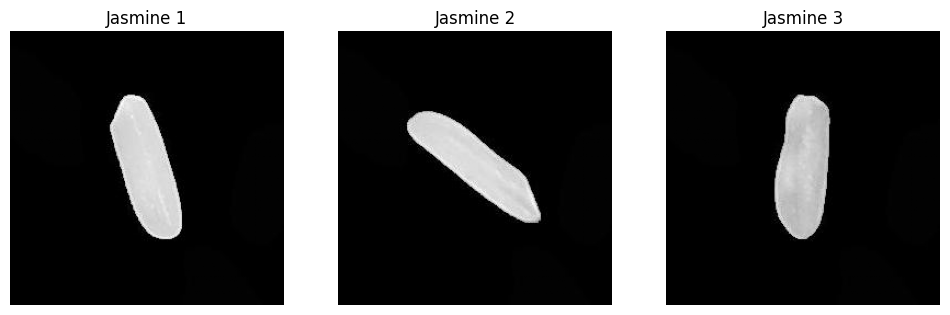

In [10]:
#Plot for Jasmine
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[45000], cmap='gray')
axes[0].set_title('Jasmine 1')
axes[0].axis('off')
axes[1].imshow(images[45001], cmap='gray')
axes[1].set_title('Jasmine 2')
axes[1].axis('off')
axes[2].imshow(images[45002], cmap='gray')
axes[2].set_title('Jasmine 3')
axes[2].axis('off')
fig.show()

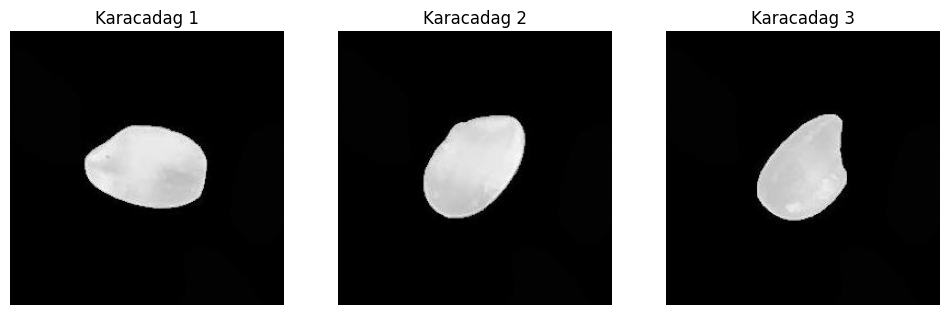

In [11]:
#Plot for Karacadag
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[60000], cmap='gray')
axes[0].set_title('Karacadag 1')
axes[0].axis('off')
axes[1].imshow(images[60001], cmap='gray')
axes[1].set_title('Karacadag 2')
axes[1].axis('off')
axes[2].imshow(images[60002], cmap='gray')
axes[2].set_title('Karacadag 3')
axes[2].axis('off')
fig.show()

###Transform to Grayscale

Since the images do not have much color in them, I decided to convert them all to grayscale in order to reduce the size of each from (250x250x3) to just (250x250). The code above (up where the data is loaded in) uses a weight matrix that I found online and does a dot product with each image to reduce it to just the one dimension. This preserves the relative brightnesses well. After this I just display the new shape to confirm that it worked.

###Formatting Response Vector and Train-Test Split

In [12]:
#Response and predictor set up, with 80-20 train test split
X_train, X_test, y_train_f, y_test_f = train_test_split(images, labels, test_size=0.2, random_state=3261, shuffle=True)
y_train = pd.get_dummies(y_train_f, dtype=int)
y_test = pd.get_dummies(y_test_f, dtype=int)
del images #Frees up some space

#Analysis and Results

###The Three Models

For this analysis I decided to use three different models, one with a supervised classification method, and two deep learning models, one standard and one convolutional. For the classification model we will use k nearest neighbors with 5 neighbors. This works by looking at the closest 5 neighbors (closest image by pixel values) and taking a weighted vote of these to decide on the class the test image should be in. The standard neural network works by flattening the image and then running two dense hidden layers (one 64 and one 32 node layer). The convolutional neural network runs two 3x3 convolutions on the image with dropout layer, before feeding into a 64 node hidden layer. Below I build and train each of these models, the detailed tensorflow descriptions are below.

In [14]:
#Flatten out the images
X_train_flat = [img.flatten() for img in X_train]
X_test_flat = [img.flatten() for img in X_test]

#Create and train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train_f)

#Predict KNN model and time it
t = time.time()
knn_test_preds = knn.predict(X_test_flat)
print(time.time()-t)

439.7191255092621


In [15]:
#Build standard neural network
nn = models.Sequential()
nn.add(layers.InputLayer(shape=(250,250)))
nn.add(layers.Flatten())
nn.add(layers.Dense(64, activation='relu'))
nn.add(layers.Dense(32, activation='relu'))
nn.add(layers.Dense(5, activation='sigmoid'))
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 62500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,000,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,002,309 (15.27 MB)

 Trainable params: 4,002,309 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#Compile, train, and predict with neural network model
nn.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
nn_history = nn.fit(X_train, y_train, epochs=5)
nn_train_preds = nn.predict(X_train)
nn_test_preds = nn.predict(X_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8530 - loss: 10.3928
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9490 - loss: 1.3635
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9528 - loss: 0.4432
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9395 - loss: 0.2497
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9328 - loss: 0.1655
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [17]:
#Build CNN with two convolutional layers
cnn = models.Sequential()
cnn.add(layers.InputLayer(shape=(250,250,1)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(5, activation='sigmoid'))
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 119072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     7,620,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,640,101 (29.14 MB)

 Trainable params: 7,640,101 (29.14 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Compile, train, and predict with CNN
cnn.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn_history = cnn.fit(X_train, y_train, epochs=5)
cnn_train_preds = cnn.predict(X_train)
cnn_test_preds = cnn.predict(X_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8950 - loss: 0.4511
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9757 - loss: 0.0308
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9832 - loss: 0.0203
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9905 - loss: 0.0124
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9939 - loss: 0.0078
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


###Deep Model Comparisons

The graph below shows the accuracy vs epoch graph for the standard neural network and the convolutional one. From this we see that the CNN continues to learn and is high accuracy compared to the NN model. The NN model also stops improving after the third epoch, and starts to lose accuracy, which is probably because of having too many paramaters to train, so the gradients are not being correctly calculated.

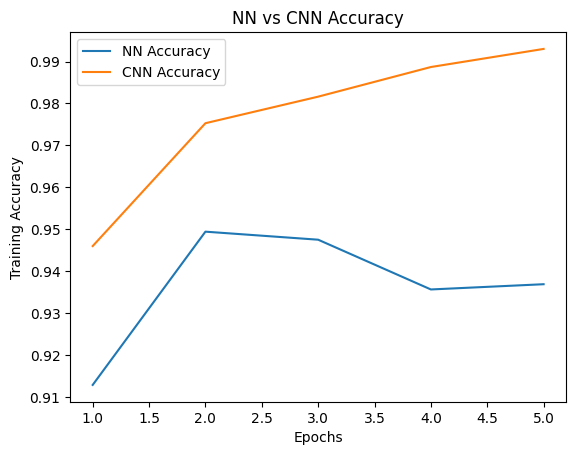

In [19]:
#Plot of accuracy vs epochs for the two neural network models
epochs = range(1,6)
plt.plot(epochs, nn_history.history['accuracy'], label='NN Accuracy')
plt.plot(epochs, cnn_history.history['accuracy'], label='CNN Accuracy')
plt.title('NN vs CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

###Confusion Matrices

Below I have three confusion matrices for the three models with the testing accuracy listed as well. For the KNN model, the confusion matrix looks pretty well balanced, with the largest incorrect predictions being between Karacadag-Arborio, and Jasmine-Basmati. The accuracy was quite high at 0.9767. The NN model has the lowest accuracy of the three, but is still reasonably high at 0.9587. The confusion matrix shows similar, with Karacadag-Arborio and Jasmine-Basmati being high, but also has Jasmine-Ipsala being high. Lastly, the CNN model had an accuracy of 0.9711, close to the KNN but not exactly. The confusion matrix here looks very similar to the one for KNN as well.

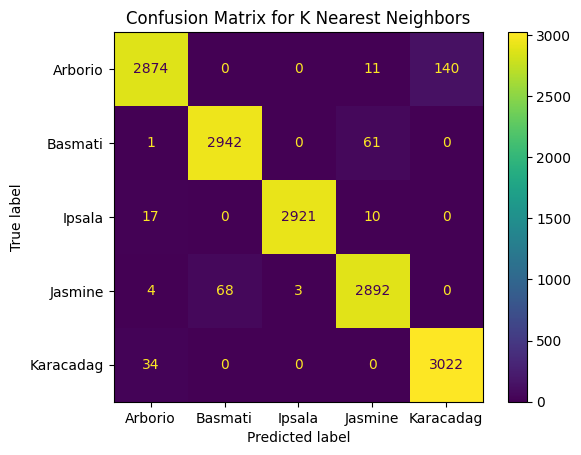

Testing accuracy is: 0.9767333333333333


In [20]:
#Make response numeric and get the category titles
unique, y_test_n = np.unique(y_test_f, return_inverse=True)

#Create and plot KNN confusion matrix
cm = confusion_matrix(y_test_f, knn_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique)
disp.plot()
plt.title("Confusion Matrix for K Nearest Neighbors")
plt.show()
np.argmax(nn_test_preds, axis=1)
print("Testing accuracy is: " + str(accuracy_score(y_test_f, knn_test_preds)))

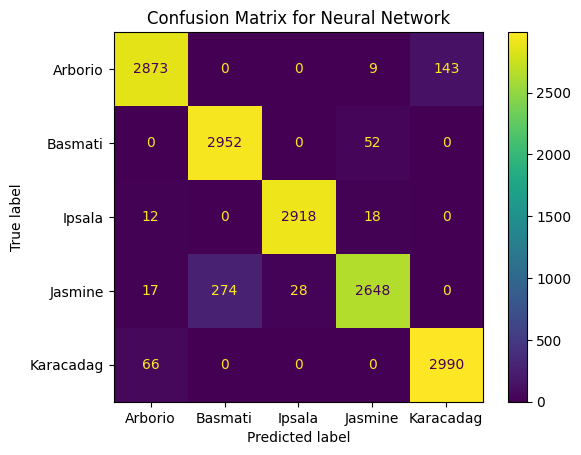

Testing accuracy is: 0.9587333333333333


In [21]:
#Create and plot NN confusion matrix
cm = confusion_matrix(y_test_n, np.argmax(nn_test_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique)
disp.plot()
plt.title("Confusion Matrix for Neural Network")
plt.show()
np.argmax(nn_test_preds, axis=1)
print("Testing accuracy is: " + str(accuracy_score(y_test_n, np.argmax(nn_test_preds, axis=1))))

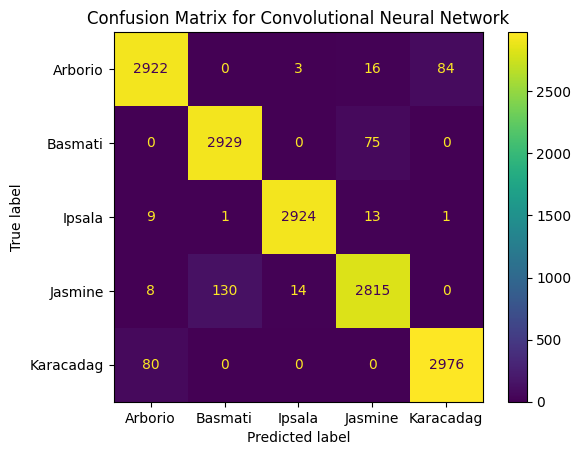

Testing accuracy is: 0.9710666666666666


In [22]:
#Create and plot CNN confusion matrix
cm = confusion_matrix(y_test_n, np.argmax(cnn_test_preds, axis=1))
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine','Karacadag']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique)
disp.plot()
plt.title("Confusion Matrix for Convolutional Neural Network")
plt.show()
print("Testing accuracy is: " + str(accuracy_score(y_test_n, np.argmax(cnn_test_preds, axis=1))))

###Hyperparameter Tuning

For my hyperparameter tuning, I want to look at increasing the number of convolutional layers in the CNN model, and see how that affects performance. I decided to fit a model with 3 convolutional layers, and one with four convolutional layers to compare to the model with two layers that I fit above. The detailed tensorflow descripions are below.

In [23]:
#Create CNN model with three convolutional layers
cnn_3 = models.Sequential()
cnn_3.add(layers.InputLayer(shape=(250,250,1)))
cnn_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Flatten())
cnn_3.add(layers.Dense(64, activation='relu'))
cnn_3.add(layers.Dense(5, activation='sigmoid'))
cnn_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 248, 248, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     1,722,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,751,109 (6.68 MB)

 Trainable params: 1,751,109 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Compile, train and predict ith CNN 3
cnn_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn_3_history = cnn_3.fit(X_train, y_train, epochs=5)
cnn_3_train_preds = cnn_3.predict(X_train)
cnn_3_test_preds = cnn_3.predict(X_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9172 - loss: 0.2715
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9714 - loss: 0.0349
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9751 - loss: 0.0297
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9794 - loss: 0.0241
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9857 - loss: 0.0168
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [25]:
#Build CNN with 4 convolutional layers
cnn_4 = models.Sequential()
cnn_4.add(layers.InputLayer(shape=(250,250,1)))
cnn_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Flatten())
cnn_4.add(layers.Dense(64, activation='relu'))
cnn_4.add(layers.Dense(5, activation='sigmoid'))
cnn_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 248, 248, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 122, 122, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 59, 59, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,101 (1.47 MB)

 Trainable params: 384,101 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#Compile, train, and predict with CNN 4
cnn_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn_4_history = cnn_4.fit(X_train, y_train, epochs=5)
cnn_4_train_preds = cnn_4.predict(X_train)
cnn_4_test_preds = cnn_4.predict(X_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9275 - loss: 0.1028
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9726 - loss: 0.0333
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9797 - loss: 0.0256
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9836 - loss: 0.0206
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9879 - loss: 0.0148
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


###CNN Model Evaluation
The graph below shows the learning rate for the three CNN models I compared. It appears that the first CNN model (2) learned the most and got to the highest training accuracy. The 3 and 4 layer convolutions seemed to learn a little slower. Looking at the test accuracies, the four layer model performed better, and was the best model we had on the testing data. From this it seems that adding more layers helped prevent the model from overfitting.

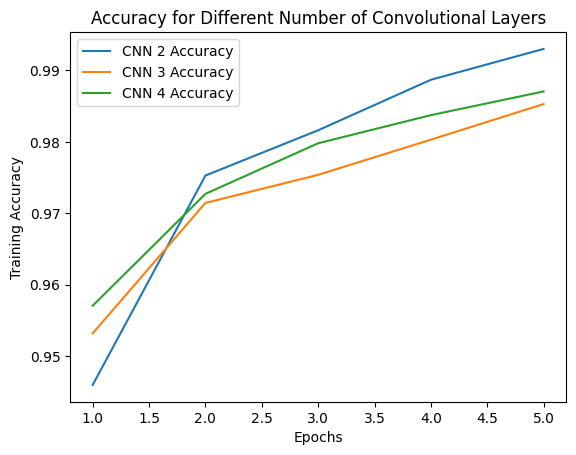

In [27]:
#Plot train accuracy vs epochs for the three CNN modes
epochs = range(1,6)
plt.plot(epochs, cnn_history.history['accuracy'], label='CNN 2 Accuracy')
plt.plot(epochs, cnn_3_history.history['accuracy'], label='CNN 3 Accuracy')
plt.plot(epochs, cnn_4_history.history['accuracy'], label='CNN 4 Accuracy')
plt.title('Accuracy for Different Number of Convolutional Layers')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

In [28]:
#Output testing accuracy of the three CNN models
print("Testing accuracy for two layers: " + str(accuracy_score(y_test_n, np.argmax(cnn_test_preds, axis=1))))
print("Testing accuracy for three layers: " + str(accuracy_score(y_test_n, np.argmax(cnn_3_test_preds, axis=1))))
print("Testing accuracy for four layers: " + str(accuracy_score(y_test_n, np.argmax(cnn_4_test_preds, axis=1))))

Testing accuracy for two layers: 0.9710666666666666
Testing accuracy for three layers: 0.9786
Testing accuracy for four layers: 0.9851333333333333


#Conclusion

Overall, I feel that all of the five different models I tried were successful at determining which images were which types of rice. All of my models got above 95% accuracy with the testing data, which is relatively good. The table below summarizes my results from the five models, looking at test accuracy, cell execution time (prediction + training), and prediction time on its own. From this data it is clear that the neural networks are much faster at prediction than the KNN, and even the slowest neural network had a cell execution time that was less than half of the KNN's run time. This happens because for all of the 15,000 test images, the KNN must calculate distances in a 62,500 dimensional space (250x250 pixels), which is very computationally intensive. The neural network techniques work by figuring out which pixels are actually important, which allows us to ignore many of those dimensions. The model which I think is te clear winner is the CNN 4 model, which uses 4 convolutional layers to process the data. This model has the highest accuracy, and takes the same amount of time as the other CNN models, while getting a slightly higher accuracy. If I worked on this project more, I would want to refine the layout of that CNN 4 model, and fine tune it more in order to try and get the accuracy higher. I would want to try different size convolution layers, and a different layout of dense layers after the analysis to see if that improves the learning. This project showed clearly the importance of using a neural netwrok approach for this type of classification task, as using the non deep learning approach takes more time and is greatly inefficient. This project also helped me get more practice with using convolutional neural networks, specifically with testing different model architectures against each other.

| Model | Test Accuracy | Cell Execution Time (min)| Prediction Time (sec) |
| :------- | :------: | :------: | :-------: |
| KNN | 0.9767 | 7 | 440 |
| NN | 0.9587 | 1 | 2 |
| CNN 2 | 0.9711 | 3 | 3 |
| CNN 3 | 0.9786 | 3 | 3 |
| CNN 4 | 0.9851 | 3 | 3 |